# Training
Here we provide interactive scripts, with which one can train a generative model. The script uses classes and functions used in the code that runs on condor in order to obtain the optimised model trained on the full dataset. 
We advise not to train the model on the full dataset here as it will take too long. Limit the training dataset size (e.g. use a single input file) and number of epochs and use this notebook to study e.g pre-processing, hyperparameters and diffusion techniques.

First, we set the environment and the various parameters for the model, hyperparameters, diffusion equations etc. We also create instances of the stochastic differential equations, machine learning model and create a list of files we want to use as input.

Important: need to set the padding value to the value used in pad_events.py script to create the padded (and transformed) dataset.

In [2]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam,RAdam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from prettytable import PrettyTable
import tqdm
from pickle import load
from IPython import display

sys.path.insert(1, '../')
#import trans_tdsm, utils
import util.data_utils as utils
import util.score_model as score_model
import util.sdes as sdes
import util.display

# GPU device info
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:516"
os.system('nvidia-smi')

# Set padding value used
padding_value = 0.0

dataset = "dataset_2_padded_nentry"
preproc_dataset_name = 'ds2_diff_transforms'
dataset_store_path = os.path.join("/eos/user/j/jthomasw/tdsm_encoder/datasets/", preproc_dataset_name)
transform = None
transform_y = None
mask = True
jupyternotebook = True
workingdir = "./"

### SDE PARAMETERS ###
SDE = 'VP'
if SDE == 'VP':
    beta_max = 1.0
    beta_min = 0.01
if SDE == 'VE':
    sigma_max = 20.0
    sigma_min = 0.1
    
### MODEL PARAMETERS ###
n_feat_dim = 4
embed_dim = 512
hidden_dim = 128
num_encoder_blocks = 8
num_attn_heads = 16
dropout_gen = 0

# Instantiate stochastic differential equation
if SDE == 'VP':
    sde = sdes.VPSDE(beta_max=beta_max,beta_min=beta_min, device=device)
if SDE == 'VE':
    sde = sdes.VESDE(sigma_max=sigma_max,sigma_min=sigma_min,device=device)
marginal_prob_std_fn = functools.partial(sde.marginal_prob)
diffusion_coeff_fn = functools.partial(sde.sde)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)

# Input files
files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, dataset + '*424To564.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)

# Instantiate model
model=score_model.Gen(n_feat_dim, embed_dim, hidden_dim, num_encoder_blocks, num_attn_heads, dropout_gen, marginal_prob_std=marginal_prob_std_fn)
torch.save(model.state_dict(), 'initial_model.pt')
table = PrettyTable(['Module name', 'Parameters listed'])
t_params = 0
for name_ , para_ in model.named_parameters():
    if not para_.requires_grad: continue
    param = para_.numel()
    table.add_row([name_, param])
    t_params+=param
print(table)
print(f'Sum of trainable parameters: {t_params}')   

Thu Jan  4 13:05:24 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:07.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   2001MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Training

The following cell will call training methods from the trans_tdsm.py script so everything should be synchronised with what we can run on condor for the big jobs.

Once you have a a fully trained model you can look at the sampling notebook to see how to generate samples and make some plots

  0%|          | 0/200 [00:00<?, ?it/s]

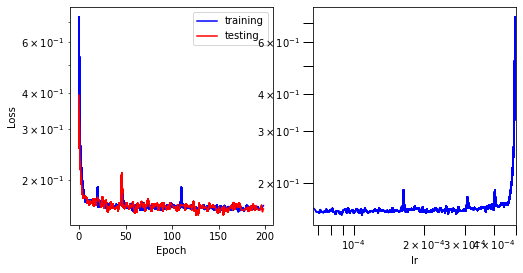

['/eos/user/j/jthomasw/tdsm_encoder/datasets/ds2_diff_transforms/dataset_2_padded_nentry424To564.pt']


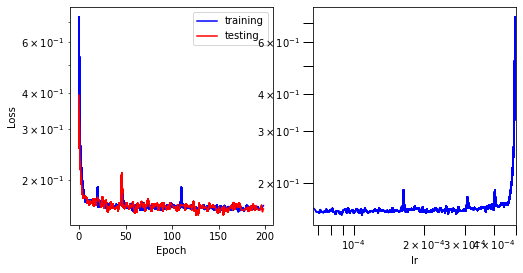

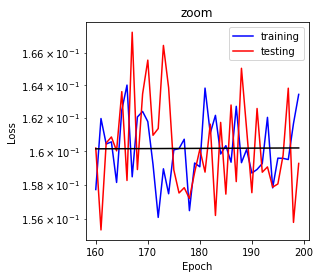

In [3]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

torch.cuda.empty_cache()

### HYPERPARAMETERS ###
train_ratio = 0.8
batch_size = 128
n_epochs = 200
epochs = tqdm.notebook.trange(n_epochs)
# Setup exponentially decaying learning rate
initial_lr = 5e-4

### Model ###
model = score_model.Gen(n_feat_dim, embed_dim, hidden_dim, num_encoder_blocks, num_attn_heads, dropout_gen, marginal_prob_std=marginal_prob_std_fn)
state_dict = torch.load('initial_model.pt')
model.load_state_dict(state_dict)

### optimiser ###
optimiser = RAdam(model.parameters(),lr=initial_lr)
scheduler = lr_scheduler.ExponentialLR(optimiser, gamma=0.99)

output_directory = workingdir+'/training_'+datetime.now().strftime('%Y%m%d_%H%M')+'_'+preproc_dataset_name+'/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
av_training_losses_per_epoch = []
av_testing_losses_per_epoch = []

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
dh = display.display(fig, display_id=True)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_yscale('log')
ax[1].set_xlabel('lr')
ax[1].set_xlim(initial_lr*0.99**(n_epochs), initial_lr)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].tick_params('both', length=10, width=1, which='both')

lrs_ = []

print(files_list_)
eps_ = []
for epoch in epochs:
    eps_.append(epoch)
    # Create/clear per epoch variables
    cumulative_epoch_loss = 0.
    cumulative_test_epoch_loss = 0.

    file_counter = 0
    n_training_showers = 0
    n_testing_showers = 0
    training_batches_per_epoch = 0
    testing_batches_per_epoch = 0

    # Load files
    for filename in files_list_:
        custom_data = utils.cloud_dataset(filename, device=device)
        train_size = int(train_ratio * len(custom_data.data))
        test_size = len(custom_data.data) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(custom_data, [train_size, test_size])
        n_training_showers+=train_size
        n_testing_showers+=test_size
        
        # Load clouds for each epoch of data dataloaders length will be the number of batches
        shower_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        shower_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        # Accumuate number of batches per epoch
        training_batches_per_epoch += len(shower_loader_train)
        testing_batches_per_epoch += len(shower_loader_test)

        # Load shower batch for training
        for i, (shower_data,incident_energies) in enumerate(shower_loader_train,0):
            # Move model to device and set dtype as same as data (note torch.double works on both CPU and GPU)
            model.to(device, shower_data.dtype)
            model.train()
            shower_data = shower_data.to(device)
            incident_energies = incident_energies.to(device)

            if len(shower_data) < 1:
                print('Very few hits in shower: ', len(shower_data))
                continue
            # Zero any gradients from previous steps
            optimiser.zero_grad()
            # Loss average for each batch
            loss = score_model.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, padding_value, device=device, diffusion_on_mask=False)
            # Accumulate batch loss per epoch
            cumulative_epoch_loss+=float(loss)
            # collect dL/dx for any parameters (x) which have requires_grad = True via: x.grad += dL/dx
            loss.backward()
            # Update value of x += -lr * x.grad
            optimiser.step()

        # Testing on subset of file
        for i, (shower_data,incident_energies) in enumerate(shower_loader_test,0):
            with torch.no_grad():
                model.eval()
                shower_data = shower_data.to(device)
                incident_energies = incident_energies.to(device)
                test_loss = score_model.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, padding_value, device=device, diffusion_on_mask=False)
                cumulative_test_epoch_loss+=float(test_loss)

    # Calculate average loss per epoch
    av_training_losses_per_epoch.append(cumulative_epoch_loss/training_batches_per_epoch)
    av_testing_losses_per_epoch.append(cumulative_test_epoch_loss/testing_batches_per_epoch)
    
    lr_ = optimiser.param_groups[0]['lr']
    epochs.set_description('Average Loss: {:5f}(Train) {:5f}(Test) {:5f}(lr)'.format(cumulative_epoch_loss/training_batches_per_epoch, cumulative_test_epoch_loss/testing_batches_per_epoch, lr_))
    ax[0].plot(av_training_losses_per_epoch[1:], c='blue', label='training')
    ax[0].plot(av_testing_losses_per_epoch[1:], c='red', label='testing')
    
    # End of epoch, change the learning rate
    before_lr = optimiser.param_groups[0]['lr']
    scheduler.step()
    after_lr = optimiser.param_groups[0]['lr']
    lrs_.append(before_lr)
    ax[1].plot(lrs_[1:], av_training_losses_per_epoch[1:], c='blue')
    if epoch == 0:
        ax[0].legend(loc='upper right')
    dh.update(fig)
    if n_epochs%5 == 0:
        torch.save(model.state_dict(), output_directory+'ckpt_tmp_'+str(epoch)+'.pth')
    
fig.savefig(output_directory+'loss_v_epoch.png')
torch.save(model.state_dict(), output_directory+'ckpt_tmp_'+str(epoch)+'.pth')

util.display.plot_loss_vs_epoch(eps_, av_training_losses_per_epoch, av_testing_losses_per_epoch, odir=output_directory, zoom=True)
